<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Importing the libraries</h3>

In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as et
import csv
# !pip install spacy
import spacy
from spacy import displacy

import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

# For word lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/niketan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/niketan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# uncomment and run if you have not downloaded en_core_web_sm
# !python -m spacy download en_core_web_sm 

In [3]:
nlp = spacy.load("en_core_web_sm")

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Importing the dataset</h3>

In [4]:
filePath = "Restaurants.xml"
root = et.parse(filePath).getroot()

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Transforming xml to csv</h3>

In [5]:
def transformXMLtoCSV(root):
    csvfile = open("restaurants.csv",'w',encoding='utf-8')
    csvfile_writer = csv.writer(csvfile)
    csvfile_writer.writerow(["id", "text", "term", "polarity"])
    
    for sentence in root:
        if sentence:
            id = sentence.attrib.get("id", None)
            if sentence.find("text") is not None:
                text = sentence.find("text").text
            else:
                text = None
            aspectTerms = sentence.find("aspectTerms")
            term = None; polarity = None
            if aspectTerms is not None:
                aspectTerm = aspectTerms.find("aspectTerm")
                if aspectTerm is not None:
                    attributes = aspectTerm.attrib
                    term = attributes.get("term", None)
                    polarity = attributes.get("polarity", None)
            if term and polarity:
                csvLine = [id, text, term, polarity]
                csvfile_writer.writerow(csvLine)

In [6]:
transformXMLtoCSV(root)

In [7]:
dataset = pd.read_csv("restaurants.csv")

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Data Exploration</h3>

In [8]:
dataset.head()

,id,text,term,polarity
0,3121,But the staff was so horrible to us.,staff,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,1634,"The food is uniformly exceptional, with a very...",food,positive
3,2846,"Not only was the food outstanding, but the lit...",food,positive
4,1458,Our agreed favorite is the orrechiete with sau...,orrechiete with sausage and chicken,positive


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2021 non-null   int64 
 1   text      2021 non-null   object
 2   term      2021 non-null   object
 3   polarity  2021 non-null   object
dtypes: int64(1), object(3)
memory usage: 63.3+ KB


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Visualizing polarities</h3>

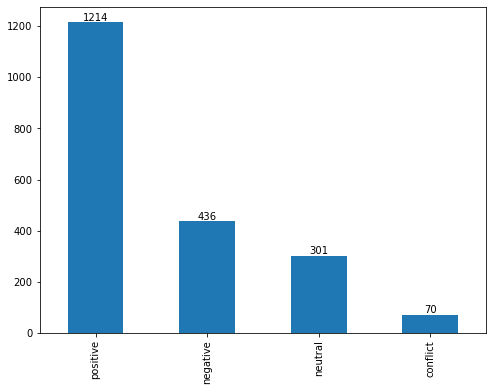

In [10]:
plt.figure(figsize=(8, 6))
splot = dataset.polarity.value_counts().plot(kind="bar")
plt.bar_label(splot.containers[0])
plt.show()

In [11]:
dataset = dataset[dataset.polarity != "conflict"]

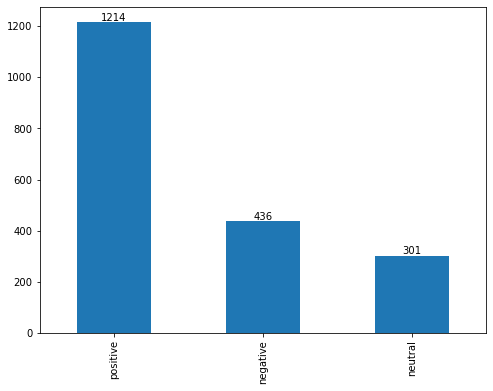

In [12]:
plt.figure(figsize=(8, 6))
splot = dataset.polarity.value_counts().plot(kind="bar")
plt.bar_label(splot.containers[0])
plt.show()

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Extracting positive words</h3>

In [13]:
positive_file = "positive-words.txt"
negative_file = "negative-words.txt"
positive_list = []
negative_list = []

In [14]:
with open(positive_file, "r") as f:
    for line in f:
        positive_list.append(line.strip())

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Extracting negative words</h3>

In [15]:
with open(negative_file, "r", encoding = "ISO-8859-1") as f:
    for line in f:
        negative_list.append(line.strip())

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">First removing all the negative and positive words from stop words</h3>

In [16]:
stopwords_list = list(spacy.lang.en.stop_words.STOP_WORDS)
for w in stopwords_list:
    if w in negative_list:
        stopwords_list.remove(w)
    if w in positive_list:
        stopwords_list.remove(w)

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Text preprocessing</h3>

### Removing punctuation

In [17]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', "", text)

def convert_to_lowercase(text):
    return text.lower()

In [18]:
dataset["text"] = dataset.text.apply(remove_punctuation)
dataset["text"] = dataset.text.apply(convert_to_lowercase)

# aspect term
dataset["term"] = dataset.term.apply(remove_punctuation)
dataset["term"] = dataset.term.apply(convert_to_lowercase)

### Tokenization and stop words removal

In [19]:
def apply_tokenization_and_remove_stopwords(text):
    # Applying tokenization
    tokens = [token.strip() for token in text.split()]
    # applying removal of stopwords
    text_no_stopwords = [word for word in tokens if word not in stopwords_list]
    return " ".join(text_no_stopwords)

In [20]:
dataset["text"] = dataset.text.apply(apply_tokenization_and_remove_stopwords)
dataset["term"] = dataset.term.apply(apply_tokenization_and_remove_stopwords)

### Lemmatization

In [21]:
# Converting the text to root word - eg. low, lower, lowest converted to low
def apply_lemmatization(sampleText):
    lemmatized_review = []
    lemmatizer = WordNetLemmatizer()
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(sampleText)
    tokens = [token.strip() for token in tokens]
    for w in tokens:
        lemmatized_review.append(lemmatizer.lemmatize(w))
    return " ".join(lemmatized_review)

In [22]:
dataset["text"] = dataset.text.apply(apply_lemmatization)
dataset["term"] = dataset.term.apply(apply_lemmatization)

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Sample Visualization of Rule 1</h3>

In [23]:
sampleSentence = "food outstanding little perk great"
sampleDoc = nlp(sampleSentence)
displacy.render(sampleDoc, style='dep', jupyter=True)

In [24]:
# Rule 1 - All childrens of aspect term
for token in sampleDoc:
    if token.text in ["food"]:
        for child in token.children:
            print(child)

outstanding
perk
great


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Rule 1</h3>

<h4 style="font-size:25px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; border-radius: 30px 30px">
 <br>
    <ol>1. Considering all childrens of topic including nouns and adjectives</ol>
</h4>

In [25]:
class CustomRule1:
    def __init__(self, dataset, positive_words, negative_words):
        self.pred_polarity_list = []
        self.sentences = dataset.text.to_list()
        self.terms = dataset.term.to_list()
        self.positive_words = positive_words
        self.negative_words = negative_words
    
    def calculatePredictedPolarities(self):
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.text in self.positive_words:
                            pred = "positive"
                        elif child.text in self.negative_words:
                            pred = "negative"
                        else:
                            pred = "neutral"
            self.pred_polarity_list.append(pred)
        return self.pred_polarity_list
    
    def calculatePredictedPolaritiesByCount(self):
        self.pred_polarity_list = []
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            positive_counts = 0
            negative_counts = 0
            neutral_counts = 0
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.text in self.positive_words:
                            positive_counts += 1
                        elif child.text in self.negative_words:
                            negative_counts += 1
                        else:
                            neutral_counts += 1
            if positive_counts > negative_counts:
                if positive_counts > neutral_counts:
                    self.pred_polarity_list.append("positive")
                else:
                    self.pred_polarity_list.append("neutral")
            else:
                if negative_counts > neutral_counts:
                    self.pred_polarity_list.append("negative")
                else:
                    self.pred_polarity_list.append("neutral")
        return self.pred_polarity_list

In [26]:
cr1Instance = CustomRule1(dataset, positive_list, negative_list)
dataset["pred_polarity"] = cr1Instance.calculatePredictedPolarities()

In [27]:
# Without stopwords removal and doing count gives 296 entries out of 1896 entries
# with stopwords removal and doing count gives 374 entries out of 1896 entries
# with stop words removal and doing no count gives 530 entries
# without stop words removal and doing no count gives 476 entries

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Performance Evaluation</h3>

In [28]:
class CustomPerformanceEvaluation:
    def __init__(self, dataset):
        self.actualPolarity = dataset.polarity.to_list()
        self.predictedPolarity = dataset.pred_polarity.to_list()
        self.precision = 0
        self.recall = 0
    
    def calculateTruePositive(self, label):
        count = 0
        for idx in range(len(self.actualPolarity)):
            if (self.actualPolarity[idx] == label) and (self.predictedPolarity[idx] == label):
                count += 1
        return count
    
    def calculateTrueNegative(self, label):
        count = 0
        for idx in range(len(self.actualPolarity)):
            if (self.actualPolarity[idx] != label) and (self.predictedPolarity[idx] != label):
                count += 1
        return count
    
    def calculateFalsePositive(self, label):
        count = 0
        for idx in range(len(self.actualPolarity)):
            if (self.actualPolarity[idx] != label) and (self.predictedPolarity[idx] == label):
                count += 1
        return count
    
    def calculateFalseNegative(self, label):
        count = 0
        for idx in range(len(self.actualPolarity)):
            if (self.actualPolarity[idx] == label) and (self.predictedPolarity[idx] != label):
                count += 1
        return count
    
    def calculatePrecision(self, truePositive, falsePositive):
        self.precision = truePositive / (truePositive + falsePositive)
        return self.precision
    
    def calculateRecall(self, truePositive, falseNegative):
        self.recall = truePositive / (truePositive + falseNegative)
        return self.recall
    
    def calculateF1Score(self):
        return (2 * self.precision * self.recall) / (self.precision + self.recall)
        

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Positive Sentiment</h3>

In [29]:
positiveInstance = CustomPerformanceEvaluation(dataset)
truePositive = positiveInstance.calculateTruePositive("positive")
trueNegative = positiveInstance.calculateTrueNegative("positive")
falsePositive = positiveInstance.calculateFalsePositive("positive")
falseNegative = positiveInstance.calculateFalseNegative("positive")

In [30]:
precision = positiveInstance.calculatePrecision(truePositive, falsePositive)
recall = positiveInstance.calculateRecall(truePositive, falseNegative)
f1Score = positiveInstance.calculateF1Score()

In [31]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.8367952522255193
Recall: 0.23228995057660626
F1 Score: 0.36363636363636365


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Negative Sentiment</h3>

In [32]:
negativeInstance = CustomPerformanceEvaluation(dataset)
truePositive = negativeInstance.calculateTruePositive("negative")
trueNegative = negativeInstance.calculateTrueNegative("negative")
falsePositive = negativeInstance.calculateFalsePositive("negative")
falseNegative = negativeInstance.calculateFalseNegative("negative")

In [33]:
precision = negativeInstance.calculatePrecision(truePositive, falsePositive)
recall = negativeInstance.calculateRecall(truePositive, falseNegative)
f1Score = negativeInstance.calculateF1Score()

In [34]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.5555555555555556
Recall: 0.08027522935779817
F1 Score: 0.1402805611222445


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Neutral Sentiment</h3>

In [35]:
neutralInstance = CustomPerformanceEvaluation(dataset)
truePositive = neutralInstance.calculateTruePositive("neutral")
trueNegative = neutralInstance.calculateTrueNegative("neutral")
falsePositive = neutralInstance.calculateFalsePositive("neutral")
falseNegative = neutralInstance.calculateFalseNegative("neutral")

In [36]:
precision = neutralInstance.calculatePrecision(truePositive, falsePositive)
recall = neutralInstance.calculateRecall(truePositive, falseNegative)
f1Score = neutralInstance.calculateF1Score()

In [37]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.1773049645390071
Recall: 0.9136212624584718
F1 Score: 0.296976241900648


In [38]:
# 1st rule - all children including adjectives and nouns
# 2nd rule - all adjectives of the topic
# 3rd rule - all nouns of the topic
# 4th rule - all nouns adjectives of the topic

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Sample Visualization of Rule 2</h3>

In [39]:
sampleSentence = "food outstanding little perk great"
sampleDoc = nlp(sampleSentence)
displacy.render(sampleDoc, style='dep', jupyter=True)

In [40]:
print("All adjectives of the aspect term")
for token in sampleDoc:
    if token.text in ["food"]:
        for child in token.children:
            if child.pos_ == "ADJ":
                print(child)

All adjectives of the aspect term
outstanding
great



<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Rule 2</h3>

<h4 style="font-size:25px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; border-radius: 30px 30px">
 <br>
    <ol>2. All adjectives of the aspect term</ol>
</h4>

In [41]:
class CustomRule2:
    def __init__(self, dataset, positive_words, negative_words):
        self.pred_polarity_list = []
        self.sentences = dataset.text.to_list()
        self.terms = dataset.term.to_list()
        self.positive_words = positive_words
        self.negative_words = negative_words
    
    def calculatePredictedPolarities(self):
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            pred = None
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "ADJ":
                            if child.text in self.positive_words:
                                pred = "positive"
                            elif child.text in self.negative_words:
                                pred = "negative"
                            else:
                                pred = "neutral"
            self.pred_polarity_list.append(pred)
        return self.pred_polarity_list
    
    def calculatePredictedPolaritiesByCount(self):
        self.pred_polarity_list = []
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            positive_counts = 0
            negative_counts = 0
            neutral_counts = 0
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "ADJ":
                            if child.text in self.positive_words:
                                positive_counts += 1
                            elif child.text in self.negative_words:
                                negative_counts += 1
                            else:
                                neutral_counts += 1
            if positive_counts > negative_counts:
                if positive_counts > neutral_counts:
                    self.pred_polarity_list.append("positive")
                else:
                    self.pred_polarity_list.append("neutral")
            else:
                if negative_counts > neutral_counts:
                    self.pred_polarity_list.append("negative")
                else:
                    self.pred_polarity_list.append("neutral")
        return self.pred_polarity_list

In [42]:
dataset = dataset.drop(labels="pred_polarity", axis=1)

In [43]:
cr2Instance = CustomRule2(dataset, positive_list, negative_list)
dataset["pred_polarity"] = cr2Instance.calculatePredictedPolarities()

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Performance Evaluation</h3>

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Positive Sentiment</h3>

In [44]:
positiveInstance = CustomPerformanceEvaluation(dataset)
truePositive = positiveInstance.calculateTruePositive("positive")
trueNegative = positiveInstance.calculateTrueNegative("positive")
falsePositive = positiveInstance.calculateFalsePositive("positive")
falseNegative = positiveInstance.calculateFalseNegative("positive")

In [45]:
precision = positiveInstance.calculatePrecision(truePositive, falsePositive)
recall = positiveInstance.calculateRecall(truePositive, falseNegative)
f1Score = positiveInstance.calculateF1Score()

In [46]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.8697788697788698
Recall: 0.2915980230642504
F1 Score: 0.43676742751388037


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Negative Sentiment</h3>

In [47]:
negativeInstance = CustomPerformanceEvaluation(dataset)
truePositive = negativeInstance.calculateTruePositive("negative")
trueNegative = negativeInstance.calculateTrueNegative("negative")
falsePositive = negativeInstance.calculateFalsePositive("negative")
falseNegative = negativeInstance.calculateFalseNegative("negative")

In [48]:
precision = negativeInstance.calculatePrecision(truePositive, falsePositive)
recall = negativeInstance.calculateRecall(truePositive, falseNegative)
f1Score = negativeInstance.calculateF1Score()

In [49]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.6818181818181818
Recall: 0.10321100917431193
F1 Score: 0.17928286852589642


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Neutral Sentiment</h3>

In [50]:
neutralInstance = CustomPerformanceEvaluation(dataset)
truePositive = neutralInstance.calculateTruePositive("neutral")
trueNegative = neutralInstance.calculateTrueNegative("neutral")
falsePositive = neutralInstance.calculateFalsePositive("neutral")
falseNegative = neutralInstance.calculateFalseNegative("neutral")

In [51]:
precision = neutralInstance.calculatePrecision(truePositive, falsePositive)
recall = neutralInstance.calculateRecall(truePositive, falseNegative)
f1Score = neutralInstance.calculateF1Score()

In [52]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.15925925925925927
Recall: 0.14285714285714285
F1 Score: 0.15061295971978983


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Sample Visualization of Rule 3</h3>

In [53]:
sampleSentence = "food outstanding little perk great"
sampleDoc = nlp(sampleSentence)
displacy.render(sampleDoc, style='dep', jupyter=True)

In [54]:
print("All nouns of the aspect term")
for token in sampleDoc:
    if token.text in ["food"]:
        for child in token.children:
            if child.pos_ == "NOUN":
                print(child)

All nouns of the aspect term
perk


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Rule 3</h3>

<h4 style="font-size:25px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; border-radius: 30px 30px">
 <br>
    <ol>3. All nouns of the aspect term</ol>
</h4>

In [55]:
class CustomRule3:
    def __init__(self, dataset, positive_words, negative_words):
        self.pred_polarity_list = []
        self.sentences = dataset.text.to_list()
        self.terms = dataset.term.to_list()
        self.positive_words = positive_words
        self.negative_words = negative_words
    
    def calculatePredictedPolarities(self):
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            pred = None
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "NOUN":
                            if child.text in self.positive_words:
                                pred = "positive"
                            elif child.text in self.negative_words:
                                pred = "negative"
                            else:
                                pred = "neutral"
            self.pred_polarity_list.append(pred)
        return self.pred_polarity_list
    
    def calculatePredictedPolaritiesByCount(self):
        self.pred_polarity_list = []
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            positive_counts = 0
            negative_counts = 0
            neutral_counts = 0
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "NOUN":
                            if child.text in self.positive_words:
                                positive_counts += 1
                            elif child.text in self.negative_words:
                                negative_counts += 1
                            else:
                                neutral_counts += 1
            if positive_counts > negative_counts:
                if positive_counts > neutral_counts:
                    self.pred_polarity_list.append("positive")
                else:
                    self.pred_polarity_list.append("neutral")
            else:
                if negative_counts > neutral_counts:
                    self.pred_polarity_list.append("negative")
                else:
                    self.pred_polarity_list.append("neutral")
        return self.pred_polarity_list

In [56]:
dataset = dataset.drop(labels="pred_polarity", axis=1)

In [57]:
cr3Instance = CustomRule3(dataset, positive_list, negative_list)
dataset["pred_polarity"] = cr3Instance.calculatePredictedPolarities()

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Performance Evaluation</h3>

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Positive Sentiment</h3>

In [58]:
positiveInstance = CustomPerformanceEvaluation(dataset)
truePositive = positiveInstance.calculateTruePositive("positive")
trueNegative = positiveInstance.calculateTrueNegative("positive")
falsePositive = positiveInstance.calculateFalsePositive("positive")
falseNegative = positiveInstance.calculateFalseNegative("positive")

In [59]:
precision = positiveInstance.calculatePrecision(truePositive, falsePositive)
recall = positiveInstance.calculateRecall(truePositive, falseNegative)
f1Score = positiveInstance.calculateF1Score()

In [60]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.8055555555555556
Recall: 0.023887973640856673
F1 Score: 0.0464


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Negative Sentiment</h3>

In [61]:
negativeInstance = CustomPerformanceEvaluation(dataset)
truePositive = negativeInstance.calculateTruePositive("negative")
trueNegative = negativeInstance.calculateTrueNegative("negative")
falsePositive = negativeInstance.calculateFalsePositive("negative")
falseNegative = negativeInstance.calculateFalseNegative("negative")

In [62]:
precision = negativeInstance.calculatePrecision(truePositive, falsePositive)
recall = negativeInstance.calculateRecall(truePositive, falseNegative)
f1Score = negativeInstance.calculateF1Score()

In [63]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.45
Recall: 0.020642201834862386
F1 Score: 0.03947368421052632


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Neutral Sentiment</h3>

In [64]:
neutralInstance = CustomPerformanceEvaluation(dataset)
truePositive = neutralInstance.calculateTruePositive("neutral")
trueNegative = neutralInstance.calculateTrueNegative("neutral")
falsePositive = neutralInstance.calculateFalsePositive("neutral")
falseNegative = neutralInstance.calculateFalseNegative("neutral")

In [65]:
precision = neutralInstance.calculatePrecision(truePositive, falsePositive)
recall = neutralInstance.calculateRecall(truePositive, falseNegative)
f1Score = neutralInstance.calculateF1Score()

In [66]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.16408876933423
Recall: 0.8106312292358804
F1 Score: 0.27293064876957496


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Sample Visualization of Rule 4</h3>

In [67]:
sampleSentence = "food outstanding little perk great"
sampleDoc = nlp(sampleSentence)
displacy.render(sampleDoc, style='dep', jupyter=True)

In [68]:
print("All adjectives of nouns inside the aspect term")
for token in sampleDoc:
    if token.text in ["food"]:
        for child in token.children:
            if child.pos_ == "NOUN":
                for grandChild in child.children:
                    if grandChild.pos_ == "ADJ":
                        print(grandChild)

All adjectives of nouns inside the aspect term
little


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Rule 4</h3>

<h4 style="font-size:25px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; border-radius: 30px 30px">
 <br>
    <ol>4. All adjectives of nouns inside the aspect term</ol>
</h4>

In [69]:
class CustomRule4:
    def __init__(self, dataset, positive_words, negative_words):
        self.pred_polarity_list = []
        self.sentences = dataset.text.to_list()
        self.terms = dataset.term.to_list()
        self.positive_words = positive_words
        self.negative_words = negative_words
    
    def calculatePredictedPolarities(self):
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            pred = None
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "NOUN":
                            for grandChild in child.children:
                                if grandChild.pos_ == "ADJ":
                                    if grandChild.text in self.positive_words:
                                        pred = "positive"
                                    elif grandChild.text in self.negative_words:
                                        pred = "negative"
                                    else:
                                        pred = "neutral"
            self.pred_polarity_list.append(pred)
        return self.pred_polarity_list
    
    def calculatePredictedPolaritiesByCount(self):
        self.pred_polarity_list = []
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            positive_counts = 0
            negative_counts = 0
            neutral_counts = 0
            for token in doc:
                if token.text in self.terms[idx].split():
                    head_rel = token.head.children
                    for child in head_rel:
                        if child.pos_ == "NOUN":
                            for grandChild in child.children:
                                if grandChild.pos_ == "ADJ":
                                    if grandChild.text in self.positive_words:
                                        positive_counts += 1
                                    elif grandChild.text in self.negative_words:
                                        negative_counts += 1
                                    else:
                                        neutral_counts += 1
            if positive_counts > negative_counts:
                if positive_counts > neutral_counts:
                    self.pred_polarity_list.append("positive")
                else:
                    self.pred_polarity_list.append("neutral")
            else:
                if negative_counts > neutral_counts:
                    self.pred_polarity_list.append("negative")
                else:
                    self.pred_polarity_list.append("neutral")
        return self.pred_polarity_list

In [70]:
dataset = dataset.drop(labels="pred_polarity", axis=1)

In [71]:
cr4Instance = CustomRule4(dataset, positive_list, negative_list)
dataset["pred_polarity"] = cr4Instance.calculatePredictedPolarities()


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Performance Evaluation</h3>

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Positive Sentiment</h3>

In [72]:
positiveInstance = CustomPerformanceEvaluation(dataset)
truePositive = positiveInstance.calculateTruePositive("positive")
trueNegative = positiveInstance.calculateTrueNegative("positive")
falsePositive = positiveInstance.calculateFalsePositive("positive")
falseNegative = positiveInstance.calculateFalseNegative("positive")

In [73]:
precision = positiveInstance.calculatePrecision(truePositive, falsePositive)
recall = positiveInstance.calculateRecall(truePositive, falseNegative)
f1Score = positiveInstance.calculateF1Score()

In [74]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.7984189723320159
Recall: 0.16639209225700163
F1 Score: 0.27539195637355146


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Negative Sentiment</h3>

In [75]:
negativeInstance = CustomPerformanceEvaluation(dataset)
truePositive = negativeInstance.calculateTruePositive("negative")
trueNegative = negativeInstance.calculateTrueNegative("negative")
falsePositive = negativeInstance.calculateFalsePositive("negative")
falseNegative = negativeInstance.calculateFalseNegative("negative")

In [76]:
precision = negativeInstance.calculatePrecision(truePositive, falsePositive)
recall = negativeInstance.calculateRecall(truePositive, falseNegative)
f1Score = negativeInstance.calculateF1Score()

In [77]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.65
Recall: 0.08944954128440367
F1 Score: 0.15725806451612906


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Neutral Sentiment</h3>

In [78]:
neutralInstance = CustomPerformanceEvaluation(dataset)
truePositive = neutralInstance.calculateTruePositive("neutral")
trueNegative = neutralInstance.calculateTrueNegative("neutral")
falsePositive = neutralInstance.calculateFalsePositive("neutral")
falseNegative = neutralInstance.calculateFalseNegative("neutral")

In [79]:
precision = neutralInstance.calculatePrecision(truePositive, falsePositive)
recall = neutralInstance.calculateRecall(truePositive, falseNegative)
f1Score = neutralInstance.calculateF1Score()

In [80]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.1703056768558952
Recall: 0.12956810631229235
F1 Score: 0.14716981132075468


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Sample Visualization of Rule 5</h3>

In [81]:
sampleSentence = "food outstanding little perk great"
sampleDoc = nlp(sampleSentence)
displacy.render(sampleDoc, style='dep', jupyter=True)

In [82]:
def sampleRecursion(token):
    for child in token.children:
        print(child.text)
        sampleRecursion(child)
        
        
print("All recurring children of the aspect term")

for token in sampleDoc:
    if token.text in ["food"]:
        if token.children:
            sampleRecursion(token)
        else:
            print("No children")
            

All recurring children of the aspect term
outstanding
perk
little
great


In [83]:
class CustomRule5:
    def __init__(self, dataset, positive_words, negative_words):
        self.pred_polarity_list = []
        self.sentences = dataset.text.to_list()
        self.terms = dataset.term.to_list()
        self.positive_words = positive_words
        self.negative_words = negative_words
    
    def iteratingChild(self, token):
        for child in token.children:
            if child.text in self.positive_words:
                return "positive"
            elif child.text in self.negative_words:
                return "negative"
            else:
                return self.iteratingChild(child)
                
        return "neutral"
                
    
    def calculatePredictedPolarities(self):
        for idx, sentence in enumerate(self.sentences):
            doc = nlp(sentence)
            pred = None
            for token in doc:
                if token.text in self.terms[idx].split():
                    if token.text in self.positive_words:
                        pred = "positive"
                    elif token.text in self.negative_words:
                        pred = "negative"
                    else:
                        if token.children:
                            pred = self.iteratingChild(token)
                        else:
                            pred = "neutral"
            self.pred_polarity_list.append(pred)
        return self.pred_polarity_list

In [84]:
dataset = dataset.drop(labels="pred_polarity", axis=1)

In [85]:
cr5Instance = CustomRule5(dataset, positive_list, negative_list)
dataset["pred_polarity"] = cr5Instance.calculatePredictedPolarities()

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Performance Evaluation</h3>

<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Positive Sentiment</h3>

In [86]:
positiveInstance = CustomPerformanceEvaluation(dataset)
truePositive = positiveInstance.calculateTruePositive("positive")
trueNegative = positiveInstance.calculateTrueNegative("positive")
falsePositive = positiveInstance.calculateFalsePositive("positive")
falseNegative = positiveInstance.calculateFalseNegative("positive")

In [87]:
precision = positiveInstance.calculatePrecision(truePositive, falsePositive)
recall = positiveInstance.calculateRecall(truePositive, falseNegative)
f1Score = positiveInstance.calculateF1Score()

In [88]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.8417910447761194
Recall: 0.23228995057660626
F1 Score: 0.3641058747579083


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Negative Sentiment</h3>

In [89]:
negativeInstance = CustomPerformanceEvaluation(dataset)
truePositive = negativeInstance.calculateTruePositive("negative")
trueNegative = negativeInstance.calculateTrueNegative("negative")
falsePositive = negativeInstance.calculateFalsePositive("negative")
falseNegative = negativeInstance.calculateFalseNegative("negative")

In [90]:
precision = negativeInstance.calculatePrecision(truePositive, falsePositive)
recall = negativeInstance.calculateRecall(truePositive, falseNegative)
f1Score = negativeInstance.calculateF1Score()

In [91]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.5316455696202531
Recall: 0.0963302752293578
F1 Score: 0.16310679611650486


<h3 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Neutral Sentiment</h3>

In [92]:
neutralInstance = CustomPerformanceEvaluation(dataset)
truePositive = neutralInstance.calculateTruePositive("neutral")
trueNegative = neutralInstance.calculateTrueNegative("neutral")
falsePositive = neutralInstance.calculateFalsePositive("neutral")
falseNegative = neutralInstance.calculateFalseNegative("neutral")

In [93]:
precision = neutralInstance.calculatePrecision(truePositive, falsePositive)
recall = neutralInstance.calculateRecall(truePositive, falseNegative)
f1Score = neutralInstance.calculateF1Score()

In [94]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Precision: 0.18241042345276873
Recall: 0.9302325581395349
F1 Score: 0.30501089324618735
